In [38]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance

In [39]:
from critical_days_module import droughts

<Axes: >

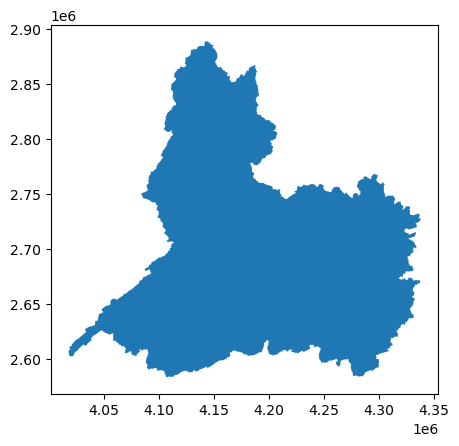

In [40]:
# name of the catchment
basin_name = "FR000119"

# defining dates for calibration
experiment_start_date = "2013-11-26T00:00:00Z"
experiment_end_date = "2019-12-31T00:00:00Z"

#Define Catchment Area
shapefile_path = Path.home() / "BEP-Elke" / "book" / "thesis_projects" / "BSc" / "2025_Q4_ElkeSchokking_CEG" / "work in progress" / "ShapefilesFR000119" / "FR000119.shp"

#check
catchment = gpd.read_file(shapefile_path)
catchment = catchment.to_crs(epsg=3035)
catchment["area_km2"] = catchment.geometry.area / 1e6  
basin_area = catchment["area_km2"].sum()
catchment.plot()

In [41]:
# Location forcing files in home directory
forcing_path = Path.home() / "forcing" / "FR000119"/"ERA5"
forcing_path.mkdir(parents=True, exist_ok=True)

In [42]:
forcing_dir = Path("/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in progress/esmvaltool_output/ewcrep5yvtlv4f_20250525_104347/work/diagnostic/script")
ERA5_forcing = sources["LumpedMakkinkForcing"].load(directory=forcing_dir)

In [43]:
# Manually parse the file
dates = []
discharges = []

with open("A3550050.csv", "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        parts = line.replace('""', '"').strip().split(',"')
        if len(parts) >= 2:
            date_str = parts[0].strip('"')
            discharge_str = parts[1].strip('"')
            try:
                dates.append(pd.to_datetime(date_str))
                discharges.append(float(discharge_str))
            except ValueError:
                continue

discharge_series = pd.Series(discharges, index=dates, name="Discharge (m³/s)")
Q_obs = discharge_series[experiment_start_date:experiment_end_date]

In [27]:
#Calibrated parameters, logNSE & EMD
par_0 = [4.533, 0.4272, 442.0109, 1.0321, 0.0714, 8.5025, 0.0139, 0.0099, 1.085]
param_names = ['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks', 'FM']

# Initial storages for HBV (in mm)
# [Si, Su, Sf, Ss, Sp]
s_0 = np.array([0, 100, 0, 5, 0])

In [28]:
# Create HBV model instance with prepared ERA5 forcing
model = HBV(forcing=ERA5_forcing)

config_file, _ = model.setup(parameters=par_0, initial_storage=s_0)
model.initialize(config_file)

In [29]:
# Run the model
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

model.finalize()

In [44]:
def convert_to_m3s(Q_mmday, area_km2):
    return Q_mmday * area_km2 * 1e3 / 86400

simulated_discharge = pd.Series(data=Q_m, index=time, name="Simulated Discharge")
Q_sim_m3s = convert_to_m3s(simulated_discharge, basin_area)
Q_sim_m3s.name = "Simulated Discharge"

In [45]:
Q_sim_m3s.index = pd.to_datetime(Q_sim_m3s.index).tz_localize(None).normalize()
Q_obs.index = pd.to_datetime(Q_obs.index).tz_localize(None).normalize()

In [46]:
# Define the calibration objective function
def calibration_objective(simulated_series: pd.Series, observed_series: pd.Series,
                          w_lognse: float = 0.7, w_emd: float = 0.3) -> float:
    sim = simulated_series.loc[observed_series.index]
    obs = observed_series

    # 1. log-NSE
    sim_pos = sim[sim > 0]
    obs_pos = obs[obs > 0]
    common_index = sim_pos.index.intersection(obs_pos.index)
    sim_log = np.log(sim_pos.loc[common_index])
    obs_log = np.log(obs_pos.loc[common_index])

    numerator = np.sum((sim_log - obs_log) ** 2)
    denominator = np.sum((obs_log - np.mean(obs_log)) ** 2)
    log_nse = 1 - (numerator / denominator) if denominator != 0 else np.inf
    error_nse = 1 - log_nse

    # 2. EMD from drought characteristics
    obs_droughts = droughts(obs, basin_name="obs", q_crit=500)
    sim_droughts = droughts(sim, basin_name="sim", q_crit=500)

    obs_durations = pd.DataFrame(obs_droughts)["Duration (days)"].values
    sim_durations = pd.DataFrame(sim_droughts)["Duration (days)"].values

    emd_duration = wasserstein_distance(obs_durations, sim_durations)
    error_emd = emd_duration

    total_score = w_lognse * error_nse + w_emd * error_emd
    return total_score


In [47]:
common_index = Q_sim_m3s.index.intersection(Q_obs.index)

sim_aligned = Q_sim_m3s.loc[common_index]
obs_aligned = Q_obs.loc[common_index]

score = calibration_objective(sim_aligned, obs_aligned)
print(f"Objective function score for par_0: {score:.4f}")

Objective function score for par_0: 1.8215